In [2]:
from utilis.utilis import *
from utilis.mdn_utilis import *
from utilis.gen_model_utilis import *
from get_datasets import *

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
import numpy as np
from scipy import spatial
from scipy.stats import norm, uniform
from tqdm import tqdm

# Mixture of linear functions dataset

### Get dataset

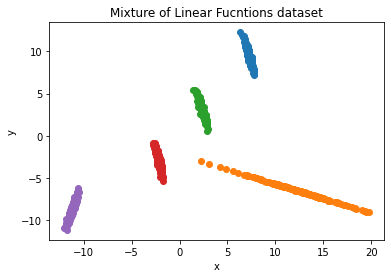

In [25]:
num_components = 5
data = get_dataset__many_linear_functions(N = 1000, num_components=num_components)
x, y, cluster_assignment, y_shift = data['train']
plot_dataset(x, y, cluster_assignment, title="Mixture of Linear Fucntions dataset")

### Train a model

In [26]:
model = simple_model(input_shape=1+num_components)

In [27]:
# one-hot-encode cluster_assignment dataset
clusters_one_hot = np.zeros((cluster_assignment.size, cluster_assignment.max()+1))
clusters_one_hot[np.arange(cluster_assignment.size), cluster_assignment] = 1

In [28]:
epochs = 50
model_input = np.concatenate([y.reshape(-1, 1), clusters_one_hot], axis=-1)
print(model_input.shape)
model.fit(model_input, x, epochs=epochs)

(900, 6)
Epoch 1/50
29/29 [==============================] - 0s 2ms/step - loss: 60.1840
Epoch 2/50
29/29 [==============================] - 0s 2ms/step - loss: 46.1239
Epoch 3/50
29/29 [==============================] - 0s 2ms/step - loss: 22.3416
Epoch 4/50
29/29 [==============================] - 0s 2ms/step - loss: 2.6285
Epoch 5/50
29/29 [==============================] - 0s 2ms/step - loss: 0.9816
Epoch 6/50
29/29 [==============================] - 0s 1ms/step - loss: 0.8424
Epoch 7/50
29/29 [==============================] - 0s 1ms/step - loss: 0.7537
Epoch 8/50
29/29 [==============================] - 0s 2ms/step - loss: 0.6658
Epoch 9/50
29/29 [==============================] - 0s 2ms/step - loss: 0.5959
Epoch 10/50
29/29 [==============================] - 0s 2ms/step - loss: 0.5415
Epoch 11/50
29/29 [==============================] - 0s 2ms/step - loss: 0.5039
Epoch 12/50
29/29 [==============================] - 0s 2ms/step - loss: 0.4763
Epoch 13/50
29/29 [==================

### Confirm model of p(x|y,c) is working

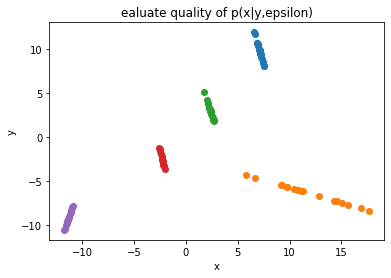

In [29]:
x_test, y_test, cluster_assignment_test, y_shifts = data['test']

# one-hot-encode cluster_assignment dataset
clusters_one_hot_test = np.zeros((cluster_assignment_test.size, cluster_assignment_test.max()+1))
clusters_one_hot_test[np.arange(cluster_assignment_test.size), cluster_assignment_test] = 1
model_input = np.concatenate([y_test.reshape(-1, 1), clusters_one_hot_test], axis=-1)

x_pred = model.predict(model_input)
plot_dataset(x_pred, y_test, cluster_assignment_test, title="ealuate quality of p(x|y,epsilon)")

### Specify some parameters for model

In [35]:
# specify number of points N_y, N_x for which to evaluate probability 
N_y = 4000
N_x = 4000
# Look at your dataset and choose x, y ranges such that they encapsulate all the points
x_range = [-15,20]
y_range = [-15,15]

In [93]:
def get_unnormalised_probability__sin_or_lin_dataset(x_query, model, num_components, y_range, N, y_shifts):
    
    min_y, max_y = y_range
    freq = (max_y - min_y) / N
    y_points = np.arange(min_y, max_y, freq)  # choose y points to evaluate p(y|x=x_query) for
    D = len(y_points)
    M = len(x_query)
    
    # get unnormalised probability p(y|x)
    unnormalised_probability__c_marginalised = np.zeros((D,M))
    for c in range(num_components):  # sum over all mixture components to marginalise c out
        if num_components > 1:
            cluster_one_hot = np.zeros((len(y_points), num_components))
            cluster_one_hot[:,c] = 1
            model_input = np.concatenate([y_points.reshape(-1, 1), cluster_one_hot], axis=-1)
        else:
            model_input = y_points
        
        x_mean = model.predict(model_input).flatten()  # assume p(x|y) is gaussian N(f(y), 0.1) => predict means


        # compute nominator
        unnormalised_probability = np.zeros((D,M))  # 
        for i in range(D):  # for each y_point evaluate p(y|x=x_query)
            p_y_c = norm.pdf(y_points[i], loc=y_shifts[c], scale=1)  # probability of y point given that c has generated y
            p_x_y_c = norm.pdf(x_query, loc=x_mean[i], scale=0.5)  # p(y|c) * p(x|y,c) = p(x,y|c)   (we multiply by p(c) later)
            unnormalised_probability[i,:] = p_y_c * p_x_y_c  # p(y,x=x_query|c) = p(y|x=x_query,c) 

        unnormalised_probability__c_marginalised += (1 / num_components) * unnormalised_probability  # marginalise c out p(c) = 1/num_sinusoids
    
    return unnormalised_probability__c_marginalised

### Get and plot conditional probability p(y|x)

In [44]:
x_sample = [-10]
p_y_given_x = get_probability__sin_or_lin_dataset(x_sample, model, num_components, y_range, N_y, y_shifts)

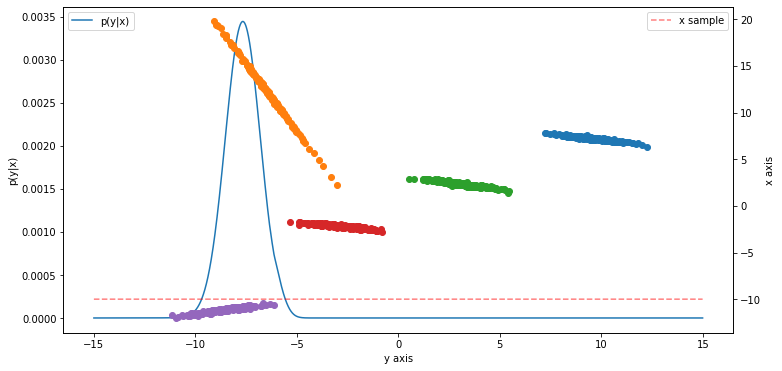

In [45]:
plot_probability(p_y_given_x, y_range, N_y, y, x, x_sample, cluster_assignment)

### Get and plot joint probability p(x,y)

In [46]:
x_queries = np.arange(x_range[0], x_range[1], (x_range[1] - x_range[0]) / N_x)
heat_map = get_probability__sin_or_lin_dataset(x_queries, model, num_components, y_range, N_y, y_shifts)

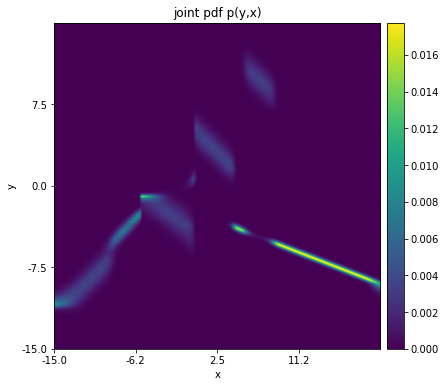

In [47]:
plot_heat_map(heat_map, x_range, y_range, N_x, N_y, tick_freq=1000)

# Mixture of inverted sinusoids

## 1. single sinusoid

\begin{align}
p(x,y,\epsilon) = p(x|y,\epsilon)p(y)p(\epsilon)
\end{align}

* $p(y)$ = Uniform(-1,1)
* $p(\epsilon)$ = N(0,0.1)
* $p(x|y,\epsilon)$ = approximate with neural network

### A. Get dataset

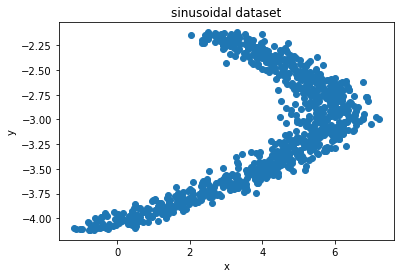

In [97]:
data = get_dataset__inverted_sinusoid(N=1000, num_sinusoids=1)
x, y, cluster_assignment, epsilon = data['train']
plot_dataset(x, y, cluster_assignment, title="sinusoidal dataset")

### B. Train $p(x|t,\epsilon)$

In [99]:
model = simple_model(input_shape=1)

In [100]:
epochs = 100
model.fit(y, x, epochs=epochs, verbose=0)

Epoch 1/100
29/29 [==============================] - 0s 2ms/step - loss: 12.8719
Epoch 2/100
29/29 [==============================] - 0s 2ms/step - loss: 5.5715
Epoch 3/100
29/29 [==============================] - 0s 2ms/step - loss: 5.2656
Epoch 4/100
29/29 [==============================] - 0s 2ms/step - loss: 5.1999
Epoch 5/100
29/29 [==============================] - 0s 2ms/step - loss: 5.2298
Epoch 6/100
29/29 [==============================] - 0s 2ms/step - loss: 5.0167
Epoch 7/100
29/29 [==============================] - 0s 2ms/step - loss: 4.9575
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 4.8517
Epoch 9/100
29/29 [==============================] - 0s 2ms/step - loss: 4.7158
Epoch 10/100
29/29 [==============================] - 0s 2ms/step - loss: 4.5644
Epoch 11/100
29/29 [==============================] - 0s 2ms/step - loss: 4.3657
Epoch 12/100
29/29 [==============================] - 0s 2ms/step - loss: 4.1164
Epoch 13/100
29/29 [================

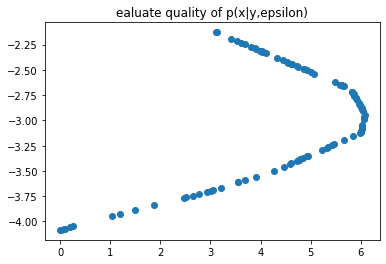

In [101]:
x_test, y_test, cluster_assignment_test, epsilon_test = data['test']

# model_input = np.stack([y_test, epsilon_test]).T
x_pred = model.predict(y_test)
plt.scatter(x_pred, y_test)
plt.title('ealuate quality of p(x|y,epsilon)')
plt.show()

### C. get $p(y|x) = \frac{\frac{1}{D}\sum^{D}_{i=1}p(x|y,\epsilon_i)p(y)p(\epsilon_i)}{\frac{1}{D}\sum^{D}_{i=1}\sum^{M}_{j=1}p(x|y_j,\epsilon_i)p(y_j)p(\epsilon_i)}$   where: $y_j \sim Uniform(-1,1)$ and $\epsilon_i \sim N(0,0.1)$

let's assume that p(x|y,epsilon) is a gaussian N(x;f(y), sigma) and that we are predicting just means assuming constant noise. So in effect we don't need to sum over epsilon because noise is implicit.

In [149]:
N_y = 500
N_x = 500
x_range = [-2,8]
y_range = [-6,0]

In [153]:
x_sample = 4
p_y_given_x = get_distribution_p_y_x(x_sample, model, y_range, N_y)

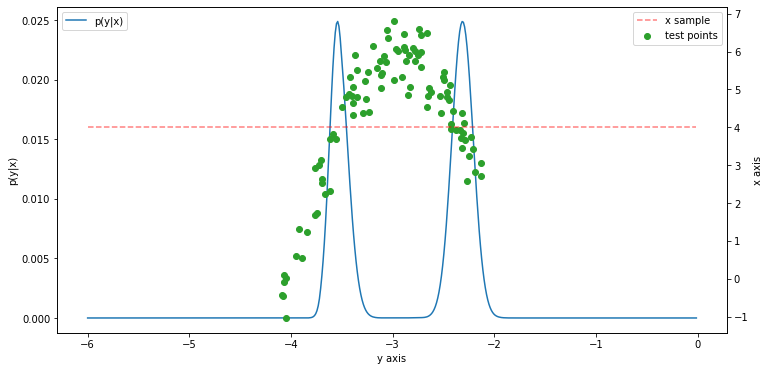

In [160]:
plot_p_y_x(p_y_given_x, y_range, N_y, y_test, x_test, x_sample)

### D. get a heatmap

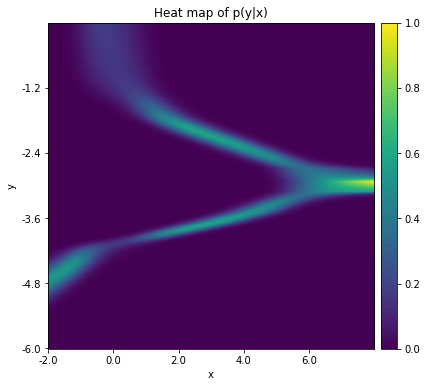

In [145]:
x_queries = np.arange(x_range[0], x_range[1], (x_range[1] - x_range[0]) / N_x)
heat_map = get_heat_map_p_y_x(x_queries, model, y_range, N_y)

plot_heat_map(heat_map, x_range, y_range, N_x, N_y)
plt.show()

## 2. mixture of sinusoids

\begin{align}
p(x,y, c, \epsilon) = p(x|y,c,\epsilon)p(y|c)p(c)p(\epsilon)
\end{align}

* $p(y|c_i) = N(g(c_i), 1)$
* $p(c)$ = Categorical_Uniform(5 categories)
* $p(\epsilon)$ = N(0,0.1)
* $p(x|y,c,\epsilon)$ = approximate with neural network

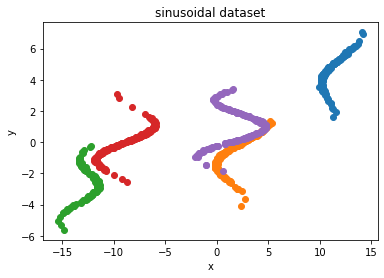

In [48]:
num_sinusoids = 5
data = get_dataset__inverted_sinusoid(N=1000, num_sinusoids=num_sinusoids)
x, y, cluster_assignment, y_shifts = data['train']
plot_dataset(x, y, cluster_assignment, title="sinusoidal dataset")

### A. Train $p(x|y,c,\epsilon)$

In [49]:
model = simple_model(input_shape=(1+num_sinusoids))

In [50]:
# one-hot-encode cluster_assignment dataset
clusters_one_hot = np.zeros((cluster_assignment.size, cluster_assignment.max()+1))
clusters_one_hot[np.arange(cluster_assignment.size), cluster_assignment] = 1

In [52]:
epochs = 200
model_input = np.concatenate([y.reshape(-1, 1), clusters_one_hot], axis=-1)
print(model_input.shape)
model.fit(model_input, x, epochs=epochs)

(900, 6)
Epoch 1/200
29/29 [==============================] - 0s 2ms/step - loss: 0.1083
Epoch 2/200
29/29 [==============================] - 0s 2ms/step - loss: 0.1037
Epoch 3/200
29/29 [==============================] - 0s 2ms/step - loss: 0.0893
Epoch 4/200
29/29 [==============================] - 0s 2ms/step - loss: 0.0901
Epoch 5/200
29/29 [==============================] - 0s 2ms/step - loss: 0.0744
Epoch 6/200
29/29 [==============================] - 0s 2ms/step - loss: 0.0809
Epoch 7/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0839
Epoch 8/200
29/29 [==============================] - 0s 3ms/step - loss: 0.1115
Epoch 9/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0725
Epoch 10/200
29/29 [==============================] - 0s 2ms/step - loss: 0.0934
Epoch 11/200
29/29 [==============================] - 0s 2ms/step - loss: 0.0655
Epoch 12/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0632
Epoch 13/200
29/29 [========

29/29 [==============================] - 0s 2ms/step - loss: 0.0279
Epoch 103/200
29/29 [==============================] - 0s 2ms/step - loss: 0.0834
Epoch 104/200
29/29 [==============================] - 0s 1ms/step - loss: 0.1465
Epoch 105/200
29/29 [==============================] - 0s 2ms/step - loss: 0.0468
Epoch 106/200
29/29 [==============================] - 0s 2ms/step - loss: 0.0270
Epoch 107/200
29/29 [==============================] - 0s 2ms/step - loss: 0.0280
Epoch 108/200
29/29 [==============================] - 0s 2ms/step - loss: 0.0503
Epoch 109/200
29/29 [==============================] - 0s 2ms/step - loss: 0.0323
Epoch 110/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0581
Epoch 111/200
29/29 [==============================] - 0s 2ms/step - loss: 0.0843
Epoch 112/200
29/29 [==============================] - 0s 2ms/step - loss: 0.0476
Epoch 113/200
29/29 [==============================] - 0s 2ms/step - loss: 0.0314
Epoch 114/200
29/29 [=========

### B. test quality of $p(x|y,c,\epsilon)$ model

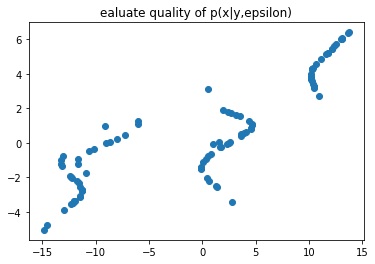

In [53]:
x_test, y_test, cluster_assignment_test, y_shifts = data['test']

# one-hot-encode cluster_assignment dataset
clusters_one_hot_test = np.zeros((cluster_assignment_test.size, cluster_assignment_test.max()+1))
clusters_one_hot_test[np.arange(cluster_assignment_test.size), cluster_assignment_test] = 1
model_input = np.concatenate([y_test.reshape(-1, 1), clusters_one_hot_test], axis=-1)

x_pred = model.predict(model_input)
plt.scatter(x_pred, y_test)
plt.title('ealuate quality of p(x|y,epsilon)')
plt.show()

### C. Get p(y|x)

In [54]:
N_y = 4000
N_x = 4000
x_range = [-18,18]
y_range = [-6,8]

In [59]:
x_sample = [0]
p_y_given_x = get_probability__sin_or_lin_dataset(x_sample, model, num_sinusoids, y_range, N_y, y_shifts)

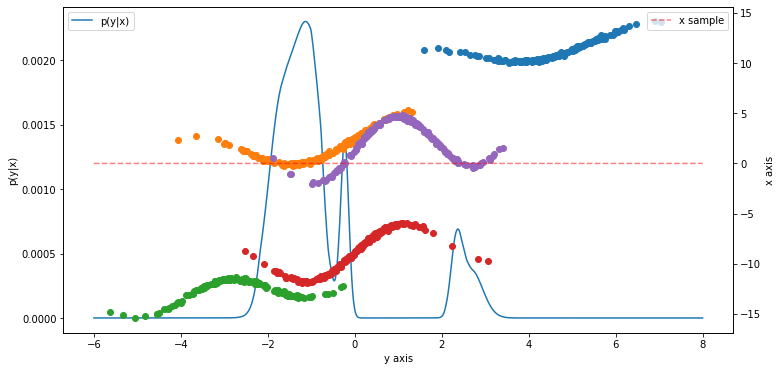

In [60]:
plot_probability(p_y_given_x, y_range, N_y, y, x, x_sample, cluster_assignment)

### Get a heatmap

In [92]:
def get_probability__sin_or_lin_dataset(x_query, model, num_clusters, y_range, N, y_shifts):
    """ Arguments are all passed to get_unnormalised_posterior__custom_dataset() function
    
    x_query: 
        if scalar: this function outputs conditional probabilty p(y|x)  -  probability
        if vector: this function outputs a joint probability p(y,x)  -  heat_map
    model: Neural Network approximating p(x|y,c) or p(x|c)
    num_clusters: number of mixtures/components - variable needed when marginalising
    y_range: range of y values for which distribution should be computed 
    N: number of y_points to space evenly in y_range 
    c_mins, c_maxs: vectors which define prior for each class p(c_i) = Uniform(c_mins[i], c_maxs[i])  """
    
    
    # compute unnormalised posterior
    arguments = [x_query, model, num_clusters, y_range, N, y_shifts]
    unnormalised_probability = get_unnormalised_probability__sin_or_lin_dataset(*arguments)
    
    # normalise posterior (applied to both conditional probability and joint probability)
    probability = unnormalised_probability / np.sum(unnormalised_probability)
    return probability

In [94]:
x_queries = np.arange(x_range[0], x_range[1], (x_range[1] - x_range[0]) / N_x)
heat_map = get_probability__sin_or_lin_dataset(x_queries, model, num_sinusoids, y_range, N_y,y_shifts)

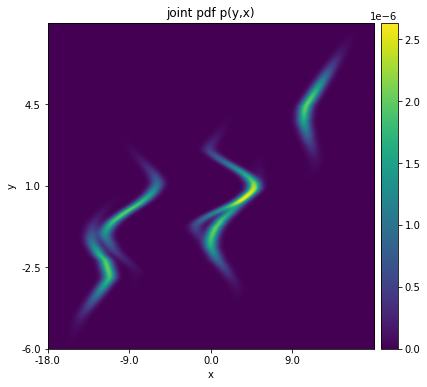

In [95]:
plot_heat_map(heat_map, x_range, y_range, N_x, N_y, tick_freq=1000)

# Our Localisation specific custom dataset

\begin{align}
p(i,c,t,\epsilon) & = p(i|c,\epsilon)p(c|t)p(\epsilon; \sigma)p(t) \\
p(t|i) & = \frac{\sum^C\sum^{\epsilon}{p(i,c,t,\epsilon)}}{\sum^T\sum^C\sum^{\epsilon}{p(i,c,t,\epsilon)}}
\end{align}

$p(t)=Uniform(-100,100)$ - prior, fully defined

$p(\epsilon; \sigma) = N(0,\epsilon) = N(0, 0.05)$ - prior, fully defined

$p(c|t)$

$p(i|c, \epsilon) = N(i; \mu(c), \sigma) = N(i; \mu(c), 0.05)$ - gaussian distirbution. Model parameters are $\mu(.)$ for each cluster *c*.

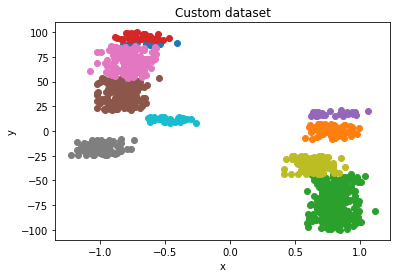

In [4]:
num_components = 10

# get dataset
data = get_dataset__simplified_localisation_problem(N=1000, C=100, num_clusters=num_components, one_to_many=True)
x, y, cluster_assignment, epsilon = data['train']
plot_dataset(x, y, cluster_assignment, title="Custom dataset")

### get a NN model to approximate p(x|c ;epsilon)

In [82]:
model = simple_model(input_shape=num_components)

In [83]:
# one-hot-encode cluster_assignment dataset
clusters_one_hot = np.zeros((cluster_assignment.size, cluster_assignment.max()+1))
clusters_one_hot[np.arange(cluster_assignment.size), cluster_assignment] = 1

In [84]:
epochs = 50

model.fit(clusters_one_hot, x, epochs=epochs)

Epoch 1/50
29/29 [==============================] - 0s 2ms/step - loss: 0.2707
Epoch 2/50
29/29 [==============================] - 0s 1ms/step - loss: 0.0167
Epoch 3/50
29/29 [==============================] - 0s 1ms/step - loss: 0.0107
Epoch 4/50
29/29 [==============================] - 0s 1ms/step - loss: 0.0108
Epoch 5/50
29/29 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 6/50
29/29 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 7/50
29/29 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 8/50
29/29 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 9/50
29/29 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 10/50
29/29 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 11/50
29/29 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 12/50
29/29 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 13/50
29/29 [==============================

### Validate NN model

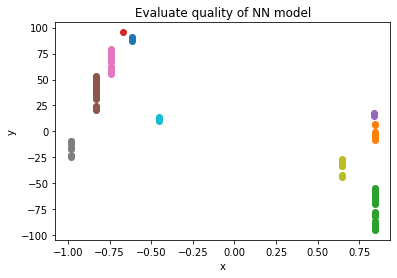

In [143]:
# visualise performance of the model. Do means for test set lie in the right clusters?
x_test, y_test, cluster_assignment_test, y_shifts = data['test']

# one-hot-encode cluster_assignment dataset
clusters_one_hot_test = np.zeros((cluster_assignment_test.size, cluster_assignment_test.max()+1))
clusters_one_hot_test[np.arange(cluster_assignment_test.size), cluster_assignment_test] = 1

x_pred = model.predict(clusters_one_hot_test)
plot_dataset(x_pred, y_test, cluster_assignment_test, title="Evaluate quality of NN model")

### Specify some parameters for computation of conditional probability p(y|x)

In [86]:
# You have to manually specify ranges for x and y. 
# Just look at your dataset visualisation and choose ranges which encapsulate all x and y values
x_range = [-2,2]
y_range = [-110,110]

# number of points to evaluate posteriors for
N_y = 4000
N_x = 4000

In [87]:
# we need to specify begining and end of each cluster to define the prior p(c_i) = Uniform(c_mins[i], c_maxs[i])
c_mins = []
c_maxs = []
for i in range(num_components):
    y_max = y[cluster_assignment == i].max()
    y_min = y[cluster_assignment == i].min()
    c_mins.append(y_min)
    c_maxs.append(y_max)

### Get and plot posterior p(y|x)

In [132]:
x_sample = [0.8]
probability_p_y_x = get_probability__custom_dataset(x_sample, model, num_components, y_range, N_y, c_mins=c_mins, c_maxs=c_maxs)

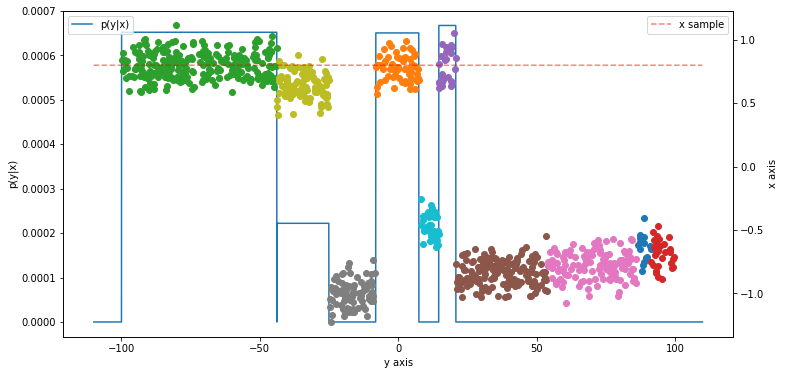

In [133]:
plot_probability(probability_p_y_x, y_range, N_y, y, x, x_sample, cluster_assignment)

### Get and plot joint probability p(x,y)

In [140]:
x_queries = np.arange(x_range[0], x_range[1], (x_range[1] - x_range[0]) / N_x)
heat_map = get_probability__custom_dataset(x_queries, model, num_components, y_range, N_y, c_mins=c_mins, c_maxs=c_maxs)

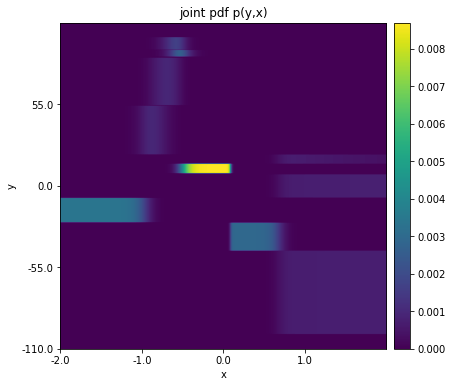

In [141]:
plot_heat_map(heat_map, x_range, y_range, N_x, N_y, tick_freq=1000)
plt.show()